# Predict Employee Burnout

## 1. Business Problem and Understanding

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import random
np.random.seed(42)
random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, \
GradientBoostingRegressor, VotingRegressor, StackingRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from xgboost import XGBRegressor
# import warnings
# warnings.filterwarnings("ignore")

## 2. Data Understanding

In [2]:
# Import data

train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')

In [3]:
# Combine train & test

full_df = pd.concat([train,test],axis=0)
full_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [4]:
# Transform column names

full_df.columns = full_df.columns.str.lower()
full_df.columns = full_df.columns.str.replace(' ','_')

It looks like we have some missing values in the last 3 columns of the data set. With so much missing from the `burn_rate` we cannot drop those values, we would ideally impute on them.

In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35000 entries, 0 to 12249
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           35000 non-null  object 
 1   date_of_joining       35000 non-null  object 
 2   gender                35000 non-null  object 
 3   company_type          35000 non-null  object 
 4   wfh_setup_available   35000 non-null  object 
 5   designation           35000 non-null  float64
 6   resource_allocation   33619 non-null  float64
 7   mental_fatigue_score  32883 non-null  float64
 8   burn_rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.7+ MB


In [6]:
full_df.isna().sum()/full_df.shape[0]*100

employee_id              0.000000
date_of_joining          0.000000
gender                   0.000000
company_type             0.000000
wfh_setup_available      0.000000
designation              0.000000
resource_allocation      3.945714
mental_fatigue_score     6.048571
burn_rate               38.211429
dtype: float64

We can see that all numeri columns are a scale, `burn_rate`, our target is from 0-1. We may want to adjust that to be on a 1-10 scale as the other variables

In [7]:
full_df.describe()

,designation,resource_allocation,mental_fatigue_score,burn_rate
count,35000.000000,33619.000000,32883.000000,21626.000000
mean,2.177514,4.473185,5.725350,0.452005
std,1.134339,2.046623,1.918292,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.500000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


## 3. Data Exporation

It looks like all of the columns with missingness are mostly normally distributed, so we can confidently impute with the mean.

mean: 0.45200545639508
median: 0.45


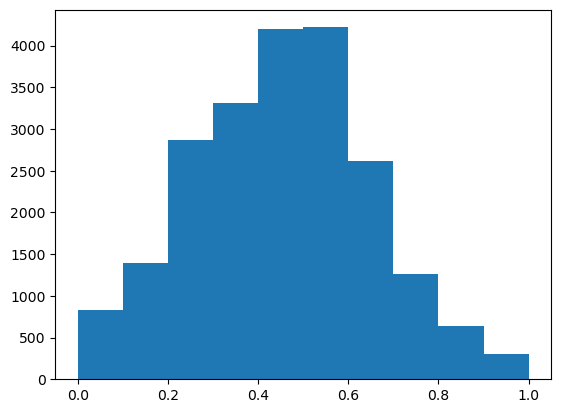

In [8]:
plt.hist(full_df['burn_rate']);

print('mean:',np.nanmean(full_df['burn_rate']))
print('median:',np.nanmedian(full_df['burn_rate']))

mean: 5.725350485053067
median: 5.9


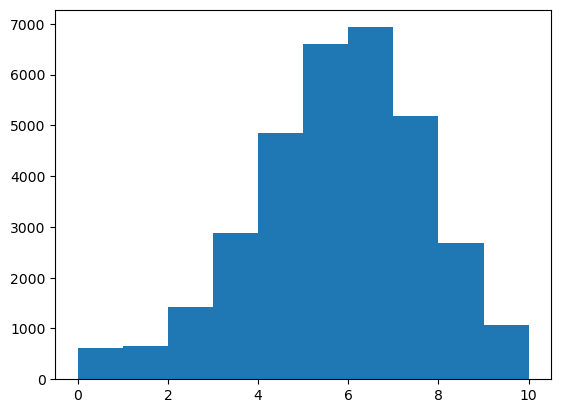

In [9]:
plt.hist(full_df['mental_fatigue_score']);

print('mean:',np.nanmean(full_df['mental_fatigue_score']))
print('median:',np.nanmedian(full_df['mental_fatigue_score']))

mean: 4.4731848062107735
median: 4.0


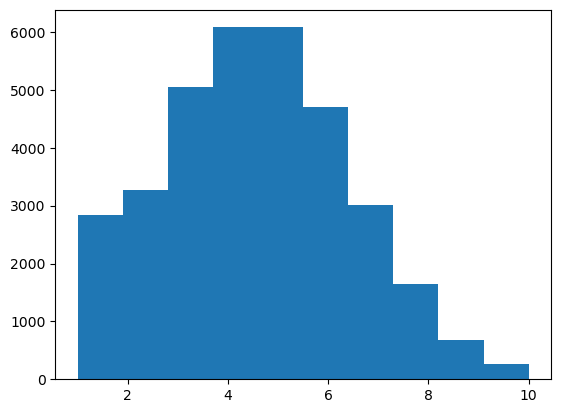

In [10]:
plt.hist(full_df['resource_allocation']);

print('mean:',np.nanmean(full_df['resource_allocation']))
print('median:',np.nanmedian(full_df['resource_allocation']))

We also don't have any duplicates so we can drop `employee_id` along with `date_of_joining` since we are working with one year.

In [11]:
full_df.duplicated(subset=['employee_id']).value_counts()

False    35000
Name: count, dtype: int64

### Target Variable `burn_rate`

Since we want to conduct a predictive model and better understand which employees are at risk of burnout, we will create a label column defining burnout. Since the metric was on a 0-1 scale, for ease of interpretation, we will increase this scale by 10 and round the number to the nearest whole number.

It looks like we have a slight class imbalance which we should try to address.

In [12]:
# full_df['burn_label'] = full_df['burn_rate'].apply(lambda x: round(x*10) if not np.isnan(x) else x)
full_df['burn_rate'].value_counts()

burn_rate
0.47    475
0.43    444
0.41    434
0.45    431
0.50    428
       ... 
0.98     18
0.97     17
0.95     17
0.96     13
0.99      8
Name: count, Length: 101, dtype: int64

Unfortunately we have to drop the missing values in our target in order to split our data into train/test. This will reduce our dataset quite a bit but hopefully we can get decent results still.

In [13]:
print('Total size after dropping target nas:',full_df.shape[0])
print('Total missing values of target:',full_df['burn_rate'].isna().sum())

y_nas_dropped = full_df.dropna(subset=['burn_rate'])

print('Total size after dropping target nas:',y_nas_dropped.shape[0])

Total size after dropping target nas: 35000
Total missing values of target: 13374
Total size after dropping target nas: 21626


### Correlation Analysis

Not surprisingly our largest correlation to `burn_rate` is `mental_fatigue_score`. Since these are so highly correlated, getting employee mental fatigue score may be a good alternative strategy to assess how employee mental health is doing.

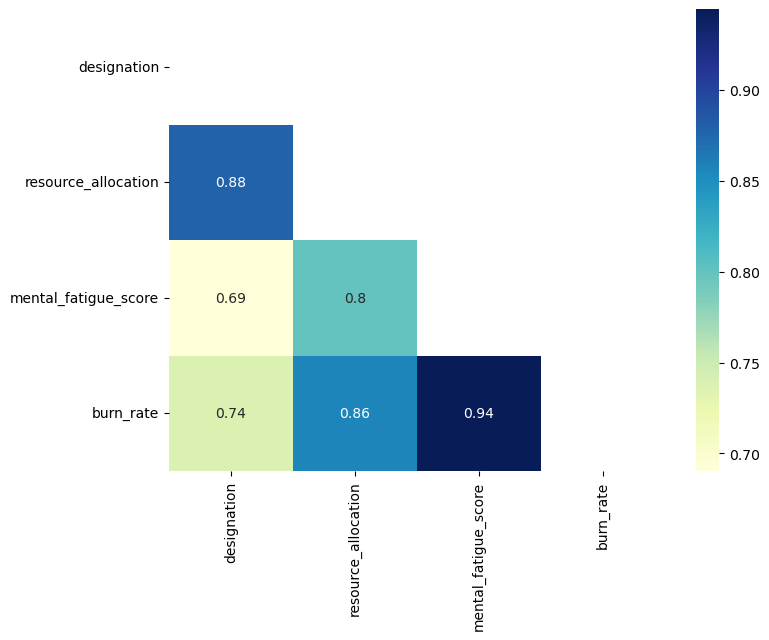

In [14]:
# Correlation analysis

fig, ax = plt.subplots(figsize=(8,6))

corr_mx = full_df.select_dtypes('number').corr()
matrix = np.triu(corr_mx)

sns.heatmap(full_df.select_dtypes('number').corr(),annot=True, mask=matrix,cmap='YlGnBu');

## 4. Data Preperation

In [15]:
# Define X, y and split train/test

X = y_nas_dropped.drop(columns=['date_of_joining','employee_id','burn_rate'])
y = y_nas_dropped['burn_rate']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)
X_train.isna().sum()

gender                     0
company_type               0
wfh_setup_available        0
designation                0
resource_allocation      964
mental_fatigue_score    1444
dtype: int64

In [16]:
# Define num and cat subpipes
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

# Create column transformer
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [3, 4, 5]),
                                         ('subpipe_cat', subpipe_cat, [0, 1, 2])],
                           remainder='passthrough')
# Initial pipeline
lr_pipe = Pipeline(steps=[('ct', CT),
                            ('model', LinearRegression())])
                            
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', LinearRegression())])

In [17]:
# Baseline score

print('Train Score:', root_mean_squared_error(y_train,lr_pipe.predict(X_train)))

Train Score: 0.07110110046632594


## 5. Linear Regression Model

First, lets see if we can improve our LinearRegression model with testing out our Lasso and Ridge models.

### Lasso

In [18]:
# Replace in pipeline

lasso_pipe = lr_pipe.set_params(model=Lasso())
lasso_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', Lasso())])

In [19]:
# Define your parameter grid
params = {
    'model__alpha':[.0001,.001,.01,1,10,100,1000],
    'model__selection': ['cyclic','random']
    
}

rcv=RandomizedSearchCV(lasso_pipe,param_distributions=params,scoring='neg_root_mean_squared_error',
                 return_train_score=True,cv=5,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 14 is smaller than n_iter=15. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'model__selection': 'cyclic', 'model__alpha': 0.0001}

We actually did worse after cross validation. It looks like our model isn't over/under fitting so that's a bonus. We may want to try a different type of model next.

In [20]:
# Create quick function to see the scores easier for future models
def rcv_metrics(rcv,model_name,X,y,train_df=None):
    best_estimator = rcv.best_estimator_
    score_dict = {'Val Train Score': -np.mean(rcv.cv_results_['mean_train_score']),
                 'Val Test Score':-np.mean(rcv.cv_results_['mean_test_score']),
                 'Model Name': model_name}
    score_df = pd.DataFrame(score_dict,columns=['Model Name','Val Train Score',
                                                'Val Test Score'], index=range(1))
    if train_df is None:
        pass
    else:
       score_df = pd.concat([train_df,score_df])
       score_df.index = range(len(score_df))
    return score_df, best_estimator
    
train_scores, lasso_best = rcv_metrics(rcv,'Lasso',X_train,y_train)
train_scores

,Model Name,Val Train Score,Val Test Score
0,Lasso,0.144035,0.144056


Our score on our test is around the same as on our train, so we know there is no overfitting or underfitting.

In [21]:
# Function to dislay f1 score and confusion matrix
def test_metrics(model,model_name,X,y,test_df=None):
    score_dict = {'Model Name':model_name,
                  'Train Score': root_mean_squared_error(y_train,model.predict(X_train)),
                  'Test Score': root_mean_squared_error(y, model.predict(X))}
    score_df=pd.DataFrame(score_dict,columns=['Model Name','Train Score','Test Score'],index=range(1))
    if test_df is None:
        pass
    else:
       score_df = pd.concat([test_df,score_df])
       score_df.index = range(len(score_df))
       score_df.sort_values(by='Test Score')
    return score_df
    

# Predict on the test
test_scores = test_metrics(lasso_best,'Lasso',X_test,y_test)
test_scores

,Model Name,Train Score,Test Score
0,Lasso,0.071102,0.071528


### Ridge

Now we can assess the Ridge model in comparison to Lasso to see which type of regularization is best for our problem.

In [22]:
# Replace in pipeline

ridge_pipe = lr_pipe.set_params(model=Ridge())
ridge_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', Ridge())])

In [23]:
# Define your parameter grid
params = {
    'model__alpha':[.0001,.001,.01,1,10,100,1000],
    'model__solver': ['auto','svd','cholesky','lsqr','sag'],
    'model__tol': [1e-5,1e-3,1e-2,1e-1]
    
    
}
rcv=RandomizedSearchCV(ridge_pipe,param_distributions=params,scoring='neg_root_mean_squared_error',
                 return_train_score=True,cv=5,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

{'model__tol': 0.001, 'model__solver': 'auto', 'model__alpha': 10}

Our Ridge model did so much better than the Ridge on the validation scores and around the same on our test, It is definitely the stronger of the two models

In [24]:
# Get train and test metrics
train_scores, ridge_best = rcv_metrics(rcv,'Ridge',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(ridge_best,'Ridge',X_test,y_test,test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,Lasso,0.144035,0.144056
1,Ridge,0.071179,0.071230


,Model Name,Train Score,Test Score
0,Lasso,0.071102,0.071528
1,Ridge,0.071101,0.071522


## 6. DecisionTree Regressors

Let's see if Decision Tree regressors can improve our scores

### Decision Tree

Next we will try a simple Decision Tree to see if the bagging and subspace sampling can get us a more stable score between model and cross validation.

In [25]:
# Replace in pipeline

dec_pipe = ridge_pipe.set_params(model=DecisionTreeRegressor(random_state=42))
dec_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [26]:
# Randomizedsearch CV 

params = {'model__criterion': ['squared_error', 'absolute_error','poisson'],
          'model__max_depth': [None, 10, 20, 30, 40],
          'model__min_samples_split': [2, 5, 10, 20],
          'model__splitter': ['best', 'random'],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv = RandomizedSearchCV(dec_pipe,param_distributions=params,scoring='neg_root_mean_squared_error',
                        return_train_score=True,random_state=42,n_iter=15)

rcv.fit(X_train,y_train)
rcv.best_params_

{'model__splitter': 'best',
 'model__min_samples_split': 20,
 'model__min_samples_leaf': 10,
 'model__max_depth': 20,
 'model__criterion': 'poisson'}

Looks like our Decision Tree did better than our Ridge but it is underfitting a bit, so hopefully the Random Forest and help address that.|

In [27]:
# Get train and test metrics
train_scores, dec_best = rcv_metrics(rcv,'Decision',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(dec_best,'Decision',X_test,y_test,test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,Lasso,0.144035,0.144056
1,Ridge,0.071179,0.071230
2,Decision,0.055158,0.065584


,Model Name,Train Score,Test Score
0,Lasso,0.071102,0.071528
1,Ridge,0.071101,0.071522
2,Decision,0.056194,0.061200


### Random Forest

Since Random Forests are better at addressing over/under fitting, we will try to see if we can improve our model with this ensemble model.

In [28]:
# Replace Regressor in pipeline

forest_pipe = ridge_pipe.set_params(model=RandomForestRegressor(random_state=42))
forest_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', RandomForestRegressor(random_state=42))])

It takes quite a bit to go through all the options available for some of these ensemble models so we will add a verbose of 3 for these to make sure that the code is running.

In [29]:
# Randomizedsearch CV 

params = {'model__criterion': ['squared_error', 'poisson'],
          'model__max_depth': [None, 10, 20, 30, 40],
          'model__min_samples_split': [2, 5, 10, 20],
          'model__warm_start': [True,False],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv = RandomizedSearchCV(forest_pipe,param_distributions=params,scoring='neg_root_mean_squared_error',
                        return_train_score=True,random_state=42,n_iter=15,verbose=3)

rcv.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END model__criterion=poisson, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=20, model__warm_start=False;, score=(train=-0.055, test=-0.060) total time=   0.7s
[CV 2/5] END model__criterion=poisson, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=20, model__warm_start=False;, score=(train=-0.055, test=-0.060) total time=   0.7s
[CV 3/5] END model__criterion=poisson, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=20, model__warm_start=False;, score=(train=-0.055, test=-0.060) total time=   0.7s
[CV 4/5] END model__criterion=poisson, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=20, model__warm_start=False;, score=(train=-0.055, test=-0.060) total time=   0.7s
[CV 5/5] END model__criterion=poisson, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=20, model__warm_start=False;, score=(

RandomizedSearchCV(estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               [3,
                                                                                4,
                                                                                5]),
                                                                              ('subpipe_cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               [0,
                                                                                1,
                                                                                2])])),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=15,
                   param_distributions={'model__criterion': ['squared_error',
                                                             'poisson'],
                                        'model__max_depth': [None, 10, 20, 30,
                                                             40],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20],
                                        'model__warm_start': [True, False]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=3)

In [30]:
rcv.best_params_

{'model__warm_start': True,
 'model__min_samples_split': 20,
 'model__min_samples_leaf': 2,
 'model__max_depth': 30,
 'model__criterion': 'squared_error'}

The Random Forest did even better than our Decision Tree on the validation data and test daya. However, it is still underfitting a bit. Next we will try some boosting models.

In [31]:
# Get train and test metrics
train_scores, forest_best = rcv_metrics(rcv,'Forest',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(forest_best,'Forest',X_test,y_test,test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,Lasso,0.144035,0.144056
1,Ridge,0.071179,0.071230
2,Decision,0.055158,0.065584
3,Forest,0.054032,0.061090


,Model Name,Train Score,Test Score
0,Lasso,0.071102,0.071528
1,Ridge,0.071101,0.071522
2,Decision,0.056194,0.061200
3,Forest,0.054973,0.059807


## 7. Boosting Regressors

Lets see boosting Regressors yeild better results, starting with `GradientRegressor` first.

### GradientBoost

In [32]:
# Replace in pipeline

gradient_pipe = ridge_pipe.set_params(model=GradientBoostingRegressor(random_state=42))
gradient_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model', GradientBoostingRegressor(random_state=42))])

We will set verbose to 3 so that we can confirm the code is running as this CV takes a bit for the boosting algorithms to run when there are this many hyperparameters to tune.

In [33]:
# Randomizedsearch CV 

params_gb = {'model__max_depth': [3, 5, 10, None],
          'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [50, 100, 200, 300, 400],
          'model__min_samples_split':  [2, 5, 10, 20],
          'model__max_features': ['sqrt','log2',None],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__min_samples_leaf': [1, 2, 5, 10]
          
}

rcv_gb = RandomizedSearchCV(gradient_pipe,param_distributions=params_gb,scoring='neg_root_mean_squared_error',
                        return_train_score=True,random_state=42,n_iter=18,verbose=3)

rcv_gb.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END model__learning_rate=0.1, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.75;, score=(train=-0.048, test=-0.066) total time=   1.2s
[CV 2/5] END model__learning_rate=0.1, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.75;, score=(train=-0.048, test=-0.066) total time=   1.2s
[CV 3/5] END model__learning_rate=0.1, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.75;, score=(train=-0.048, test=-0.067) total time=   1.2s
[CV 4/5] END model__learning_rate=0.1, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.75;, score=(train=-0.048,

RandomizedSearchCV(estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               [3,
                                                                                4,
                                                                                5]),
                                                                              ('subpipe_cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               [0,
                                                                                1,
                                                                                2])])),
                                             ('model',
                                              GradientBoostingRegressor...
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2,
                                                                 0.3],
                                        'model__max_depth': [3, 5, 10, None],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20],
                                        'model__n_estimators': [50, 100, 200,
                                                                300, 400],
                                        'model__subsample': [0.5, 0.75, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=3)

In [34]:
# Print parameters of best estimate
rcv_gb.best_params_

{'model__subsample': 0.75,
 'model__n_estimators': 300,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_features': None,
 'model__max_depth': 3,
 'model__learning_rate': 0.1}

Our Gradient Boost is underfitting on the validation data but not so much on the train/test data.

In [35]:
# Get train and test metrics
train_scores, gradient_best = rcv_metrics(rcv_gb,'GradientBoost',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(gradient_best,'GradientBoost',X_test,y_test,test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,Lasso,0.144035,0.144056
1,Ridge,0.071179,0.071230
2,Decision,0.055158,0.065584
3,Forest,0.054032,0.061090
4,GradientBoost,0.061537,0.072986


,Model Name,Train Score,Test Score
0,Lasso,0.071102,0.071528
1,Ridge,0.071101,0.071522
2,Decision,0.056194,0.061200
3,Forest,0.054973,0.059807
4,GradientBoost,0.058550,0.059716


### XGBoost

In [36]:
# Replace Regressor in pipeline

xgboost_pipe = ridge_pipe.set_params(model=XGBRegressor(random_state=42))
xgboost_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [37]:
# Randomizedsearch CV 

params_xgb = {'model__learning_rate':  [0.01, 0.05, 0.1, 0.3, 0.5],
          'model__n_estimators': [50, 100, 200, 300, 400],
          'model__min_child_weight':  [3, 5, 7, 9, 11],
          'model__colsample_bytree': [0.5, 0.75, 1.0],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__reg_alpha':  [0, 0.1, 0.5, 1.0],
          'model__reg_lambda':  [0, 0.1, 0.5, 1.0],
          'model__max_depth': [3, 5, 7, 9, 11]
}

rcv_xgb = RandomizedSearchCV(xgboost_pipe,param_distributions=params_xgb,scoring='neg_root_mean_squared_error',
                        return_train_score=True,random_state=42,n_iter=12,verbose=3)

rcv_xgb.fit(X_train,y_train)
rcv_xgb.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model__colsample_bytree=0.5, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=3, model__n_estimators=400, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.5;, score=(train=-0.053, test=-0.062) total time=   0.5s
[CV 2/5] END model__colsample_bytree=0.5, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=3, model__n_estimators=400, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.5;, score=(train=-0.053, test=-0.062) total time=   0.5s
[CV 3/5] END model__colsample_bytree=0.5, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=3, model__n_estimators=400, model__reg_alpha=0, model__reg_lambda=0.1, model__subsample=0.5;, score=(train=-0.053, test=-0.062) total time=   0.5s
[CV 4/5] END model__colsample_bytree=0.5, model__learning_rate=0.1, model__max_depth=9, model__min_child_weight=3, model__n_estimators=400, model__reg_alpha=0, mo

{'model__subsample': 0.75,
 'model__reg_lambda': 0.5,
 'model__reg_alpha': 0.1,
 'model__n_estimators': 400,
 'model__min_child_weight': 9,
 'model__max_depth': 5,
 'model__learning_rate': 0.1,
 'model__colsample_bytree': 0.75}

In [38]:
# Print parameters of the best estimator
rcv_xgb.best_params_

{'model__subsample': 0.75,
 'model__reg_lambda': 0.5,
 'model__reg_alpha': 0.1,
 'model__n_estimators': 400,
 'model__min_child_weight': 9,
 'model__max_depth': 5,
 'model__learning_rate': 0.1,
 'model__colsample_bytree': 0.75}

Very similar results as our Gradient Boost, our validation scores are slightly higher so this model might have a bit more variance. This model is also underfitting slighly more on our train/test data, with test scores nearly the same.

In [39]:
# Get train and test metrics
train_scores, xgb_best = rcv_metrics(rcv_xgb,'XGBoost',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(xgb_best,'XGBoost',X_test,y_test,test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,Lasso,0.144035,0.144056
1,Ridge,0.071179,0.071230
2,Decision,0.055158,0.065584
3,Forest,0.054032,0.061090
4,GradientBoost,0.061537,0.072986
5,XGBoost,0.066447,0.070140


,Model Name,Train Score,Test Score
0,Lasso,0.071102,0.071528
1,Ridge,0.071101,0.071522
2,Decision,0.056194,0.061200
3,Forest,0.054973,0.059807
4,GradientBoost,0.058550,0.059716
5,XGBoost,0.056742,0.059386


### AdaBoost

The last boosting model we'll try is AdaBoost with our XGBoost as our base estimator since it had the best score with the least underfitting.

In [40]:
# Replace Regressor in pipeline

ada_pipe = ridge_pipe.set_params(model=AdaBoostRegressor(random_state=42,estimator=xgb_best['model']))
ada_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [3, 4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2])])),
                ('model',
                 AdaBoostRegressor(estimator=XGBRegressor(base_score=No...
                                                          grow_policy=None,
                                                          importance_type=None,
                                                          interaction_constraints=None,
                                                          learning_rate=0.1,
                                                          max_bin=None,
                                                          max_cat_threshold=None,
                                                          max_cat_to_onehot=None,
                                                          max_delta_step=None,
                                                          max_depth=5,
                                                          max_leaves=None,
                                                          min_child_weight=9,
                                                          missing=nan,
                                                          monotone_constraints=None,
                                                          multi_strategy=None,
                                                          n_estimators=400,
                                                          n_jobs=None,
                                                          num_parallel_tree=None,
                                                          random_state=42, ...),
                                   random_state=42))])

In [ ]:
# Randomizedsearch CV 

params_ada = {'model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
          'model__n_estimators': [50, 100, 200, 300, 400],
          'model__loss': ['linear','square']
}

rcv_ada = RandomizedSearchCV(ada_pipe,param_distributions=params_ada,scoring='neg_root_mean_squared_error',
                        return_train_score=True,random_state=42,n_iter=3,verbose=3)

rcv_ada.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
rcv_ada.best_params_

Adaboost is doing slightly better than XGBoost, but not by much. It is still also still slightly underfitting.

In [ ]:
# Get train and test metrics
train_scores, ada_best = rcv_metrics(rcv_ada,'AdaBoost',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(ada_best,'AdaBoost',X_test,y_test,test_scores)
display(test_scores)

## 8. Averaging & Weighted Avereging

Lastly, we will take some of our best models and create combined models to see if we can get the best out of all of them.

### VotingRegressor

In [ ]:
# Create weighted averaging 

estimators = [
    ('gb',gradient_best),
    ('xgb',xgb_best),
    ('ada',ada_best)
]

voting_pipe = ridge_pipe.set_params(model=VotingRegressor(estimators=estimators, weights=[.2,.35,.45]))

voting_pipe.fit(X_train,y_train)

In [ ]:
# Randomizedsearch CV 

params_voting = {'model__weights': [[.2,.35,.45],[.2,.4,.4],[.1,.45,.45], [.1,.40,.50]]
}

rcv_voting = RandomizedSearchCV(voting_pipe,param_distributions=params_voting,scoring='neg_root_mean_squared_error',
                        return_train_score=True,random_state=42,n_iter=2,verbose=3)

rcv_voting.fit(X_train,y_train)

In [ ]:
# Print parameters of the beast estimator
rcv_voting.best_params_

Our AdaBoost is still our best model, the VotingRegressor did adjust the underfitting, but not significantly.

In [ ]:
# Get train and test metrics
train_scores, voting_best = rcv_metrics(rcv_voting,'Voting',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(voting_best,'Voting',X_test,y_test,test_scores)
display(test_scores)

### StackingRegressor

As our last ensemble model, we will try stacking our best models.

In [ ]:
# replace in pipe

estimators = [
    ('gb',gradient_best),
    ('xgb',xgb_best),
    ('ada',ada_best)
]

stacking_pipe = ridge_pipe.set_params(model=StackingRegressor(estimators=estimators))

stacking_pipe.fit(X_train,y_train)

In [ ]:
# Randomizedsearch CV 

params_stacking = {'model__final_estimator': [xgb_best['model'],ada_best['model']]
}

rcv_stacking = RandomizedSearchCV(stacking_pipe,param_distributions=params_stacking,scoring='neg_root_mean_squared_error',
                        return_train_score=True,random_state=42,n_iter=2,verbose=3)

rcv_stacking.fit(X_train,y_train)

In [ ]:
# Print parameters of the beast estimator
rcv_stacking.best_params_

Looks like Stacking gives us around the same results as Voting! It is also overfitting on the validation data.

In [ ]:
# Get train and test metrics
train_scores, stacking_best = rcv_metrics(rcv_stacking,'Stacking',X_train,y_train,train_scores)
display(train_scores)

test_scores = test_metrics(stacking_best,'Stacking',X_test,y_test,test_scores)
display(test_scores)